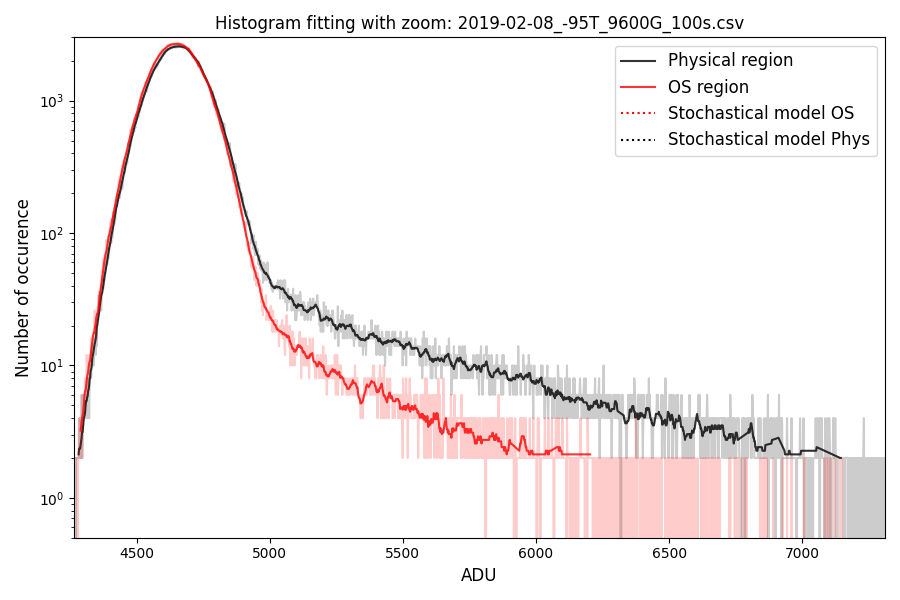

In [1]:
%matplotlib widget
%reload_ext autoreload
%autoreload 3
from ipywidgets import interact, interactive, fixed, interact_manual,Layout , VBox, HBox
import ipywidgets as widgets
import numpy as np
from scipy.sparse import dia_matrix
from astropy.table import Table
import glob
import os
import matplotlib.pyplot as plt
from pyds9plugin.DS9Utils import PlotFit1D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pyds9plugin.Macros.Fitting_Functions.functions import EMCCDhist,EMCCD, EMCCD_dev#, EMCCD_dev_wo
import io
import pandas as pd
import importlib
import time

from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings("ignore")

n_conv = 11



def init_values(bins,val,val_os,plot_=False):
    bins_os=bins
    os_v = val_os
    bias = bins_os[np.nanargmax(val_os)] +  (bins[1]-bins[0])/1 #  #ADDED xdata[np.nanargmax(ydata)]
    if bias > 1500:
        # conversion_gain = 0.53  
        smearing = 1.5 
        # gain_factor=2
        RN = 60 
    else:
        # conversion_gain = 1 / 4.5 
        smearing = 0.7  
        RN = 10
        # gain_factor=1.2
    conversion_gain=1
    gain_factor=1
    # mask_RN_os = (bins > bias - 1 * RN) & (bins < bias + 0.8 * RN) & (val_os > 0)
    mask_RN_os = (bins > bias - 1 * RN/conversion_gain) & (bins < bias + 0.8 * RN/conversion_gain) & (val_os > 0)
    if plot_:
        fig,ax = plt.subplots()
        ax.semilogy(bins,val)
        ax.semilogy(bins,val_os)
        ax.semilogy(bins[mask_RN_os],val_os[mask_RN_os],':k')
        ax.set_xlim((bins.min(),bins.max()))
        ax.set_ylim((val.min(),val_os.max()))
        # plt.show()
    else:
        ax=None

    _,_,RON,_ = np.abs(
        PlotFit1D(
            bins[mask_RN_os],
            val_os[mask_RN_os],
            deg="gaus",
            ax=ax,
            # ax=inset_axes(ax,width="30%", height="30%", loc=3),
            plot_=plot_,
            P0=[np.max(val_os[mask_RN_os]), bias, RN, 0],
        )["popt"]        / conversion_gain
    )
    function = lambda x, Bias, RN, EmGain, flux, smearing, sCIC: EMCCDhist(
        x, bias=Bias, RN=RN, EmGain=EmGain, flux=flux, smearing=smearing, sCIC=sCIC
    )

    try:
        upper_limit = bins[
            np.where(
                (bins > bias)
                & (
                    np.convolve(val, np.ones(1), mode="same")
                    == np.nanmin(val)
                )
            )[0][0]
        ]
    except (ValueError, IndexError) as e:
        upper_limit = np.max(bins)

    try:
        upper_limit_os = bins[
            np.where(
                (bins_os[np.isfinite(os_v)] > bias)
                & (
                    np.convolve(os_v[np.isfinite(os_v)], np.ones(1), mode="same")
                    == np.nanmin(os_v.min)
                )
            )[0][0]
        ]
    except (ValueError, IndexError) as e:
        upper_limit_os = np.max(bins_os)
    mask_gain1 = (bins > bias + 2 * RON) & (bins < upper_limit)
    try:
        gain = PlotFit1D(bins[mask_gain1], val[mask_gain1], ax=ax,deg='exp', plot_=plot_,P0=[np.max(val[mask_gain1]),600,0])['popt'][1]/ conversion_gain
        # (
        #     -1
        #     / np.log(10)
        #     / conversion_gain
        #     # / PlotFit1D(bins[mask_gain1], np.log10(val[mask_gain1]), ax=ax,deg=1, plot_=plot_,)[
        #     / PlotFit1D(bins[mask_gain1], val[mask_gain1], ax=ax,deg='exp', plot_=plot_,P0=[30,1000,0])[
        #         "popt"
        #     ][1]
        # )
    except ValueError:
        gain = 1200
        
        
    gain *= gain_factor 
    flux = (np.average(bins, weights=val) - np.average(bins, weights=val_os))/ (gain * conversion_gain)
    sCIC = 0.005
    gain  = np.max([np.min([gain,2000]),500])
    flux  = np.max([np.min([flux,1.5]),0.005])
    RON  = np.max([np.min([RON,150]),20])
    if plot_:
        n_pix=np.nansum( val_os[np.isfinite(val_os)]) # # 1e6#
        ax.semilogy(bins[mask_gain1],val[mask_gain1],':k')
        stoch1 = EMCCDhist(bins, bias=bias, RN=RON, EmGain=gain, flux=0, smearing=smearing, sCIC=sCIC,n_pix=n_pix)
        stoch2 = EMCCDhist(bins, bias=bias, RN=RON, EmGain=gain, flux=flux, smearing=smearing, sCIC=sCIC,n_pix=n_pix)
        # ax.semilogy(bins,10**stoch1,':',alpha=0.7)
        ax.semilogy(bins,10**stoch2,':',alpha=0.7)
    # print(bias, RON, gain, flux, smearing, sCIC)
    return bias, RON, gain, flux, smearing, sCIC
# init_values(a.x,a.y,a.y_os,plot_=True)
# a.x


fit="EMCCDhis"
if fit=="EMCCDhist":
    # EMCCD =  EMCCDhist 
    from pyds9plugin.Macros.Fitting_Functions.functions import EMCCDhist as EMCCD
else:
    from pyds9plugin.Macros.Fitting_Functions.functions import EMCCD as EMCCD


class HistogramFitter(widgets.HBox):
    def __init__(self, ):
        super().__init__()
        self.output = widgets.Output()
        self.pre_path = 'histograms/Histogram_'
        # self.pre_path = 'Histogram_'
        self.params = Table.read('parameters.csv')#,type=['S20']*20)

        self.files = glob.glob(self.pre_path+'*20??*_*G_*.csv')
        self.files.sort()
        self.options = [file.replace(self.pre_path,'') for file in self.files][::-1]
        self.file_w = widgets.Dropdown(options=self.options,value="2019-02-08_-95T_9600G_100s.csv",description='Histogram', layout=Layout(width= '430px'),continuous_update=False)#Combobox # self.options[0]

        self.file = ''

        self.year = int(self.file_w.value.split("-")[0])
        self.conversion_gain = 0.53 if self.year==2019 else 0.22

        a = Table.read(self.pre_path +self.file_w.value)
        self.x=a['col0'] #/ self.conversion_gain #- a['col0'].min()
        self.y=a['col1'] 
        self.y_os=a['col2']
        self.n_pix = np.nansum( self.y[np.isfinite(self.y)]) # # 1e6#

        np.savetxt("/tmp/xy.txt", np.array([self.x, np.log10(self.y),np.log10(self.y_os)]).T)

        # print(bias, RN, emgain, flux, smearing, sCIC)
        self.fig, self.ax = plt.subplots(figsize=(9,6))
        self.ploty = self.ax.semilogy(self.x,self.y,c='k',alpha=0.2)#,label='Physical region')
        # self.y_conv = np.convolve(self.y, np.ones(n_conv) / n_conv, mode="same")
        self.y_conv = 10**np.convolve(np.log10(self.y), np.ones(n_conv) / n_conv, mode="same")
        self.ploty_conv = self.ax.semilogy(self.x[np.isfinite(self.x)],self.y_conv[np.isfinite(self.x)],'k',alpha=0.8,label='Physical region')
        # self.ax.semilogy(self.x,10**self.y_conv_log,'k:',alpha=0.5,label='Physical region')
        self.ploty_os = self.ax.semilogy(self.x,self.y_os,c='r',alpha=0.2)#,label='OS region')
        self.y_os_conv = 10**np.convolve(np.log10(self.y_os), np.ones(n_conv) / n_conv, mode="same")
        self.ploty_os_conv = self.ax.semilogy(self.x,self.y_os_conv,c='r',alpha=0.8,label='OS region')
        bias, RN, emgain, flux, smearing, sCIC = init_values(self.x,self.y,self.y_os)
        self.stock_os = self.ax.semilogy([1,1],[1,1],':',c='r',label='Stochastical model OS')
        self.stock_phys = self.ax.semilogy([1,1],[1,1],':',c='k',label='Stochastical model Phys')
        # self.ax.semilogy(self.x,10**EMCCDhist(self.x, bias=bias, RN=RN, EmGain=emgain, flux=0, smearing=smearing, sCIC=sCIC,n_pix=self.n_pix),':',c='r',label='Stochastical model OS')
        # self.ax.semilogy(self.x,10**EMCCDhist(self.x, bias=bias, RN=RN, EmGain=emgain, flux=flux, smearing=smearing, sCIC=sCIC,n_pix=self.n_pix),':',c='k',label='Stochastical model Phys')
        self.ax.legend(loc='upper right',fontsize=12)
        self.ax.set_xlabel('ADU',fontsize=12)
        self.ax.set_ylabel('Number of occurence',fontsize=12)
        self.ax.set_xlim((self.x.min(),self.x.max()))
        self.ax.set_ylim((5e-1,1.1*self.y_os.max()))
        self.ax.set_title('Histogram fitting with zoom' )
        self.fig.tight_layout()
        width = '400px'
        # file_w = widgets.Combobox(options=options,value=path,description='Histogram', layout=Layout(width= '500px'),continuous_update=False)#Combobox

        self.bias_w = widgets.FloatSlider( min=0, max=10000,value=bias, layout=Layout(width=width),step=0.1,readout_format='.1f',description="Bias (ADU)")
        self.rn_w = widgets.FloatSlider( min=0, max=200,value=RN, layout=Layout(width=width),step=0.1,readout_format='.1f',description="RN (e-)")
        self.gain_w = widgets.FloatSlider( min=100, max=4000,value=emgain, layout=Layout(width=width),step=0.1,readout_format='.1f',description="Gain (e-/e-)")

        self.flux_w =  widgets.FloatRangeSlider(value=[0,flux],min=0.00,max=1.5,step=0.0001,readout_format='.3f', layout=Layout(width=width),description="Flux (e-)")
        self.smearing_w =  widgets.FloatSlider( min=0.0, max=1.8,step=0.01,value=smearing, layout=Layout(width=width),readout_format='.2f',description="Smearing")
        self.sCIC_w =  widgets.FloatSlider( min=0.0, max=0.2,value=sCIC,step=0.0001, layout=Layout(width=width),readout_format='.4f',description="sCIC (e-)")
        # exp_w = widgets.FloatRangeSlider( min=3, max=5,value=[4,4], layout=Layout(width='500px'))

        self.fit_w = widgets.Button(value=False,description='Fit least square',disabled=False,button_style='',tooltip='Description')#,icon='check')
        self.save_w = widgets.Button(value=True,description='Save parameters & next',disabled=False,button_style='',tooltip='Description')#,icon='check')
        self.upload_w = widgets.FileUpload(accept='*.fits',multiple=True)


        wids = widgets.interactive(self.update,file=self.file_w,bias=self.bias_w,RN=self.rn_w, EmGain=self.gain_w, flux=self.flux_w, smearing=self.smearing_w, sCIC=self.sCIC_w,upload=self.upload_w)#,fit=self.fit_w)#,SmearExpDecrement=exp)
        controls = VBox([HBox([self.file_w,self.fit_w,self.save_w,self.upload_w]),   HBox([self.bias_w,self.rn_w])     ,  HBox([self.gain_w,self.flux_w]),    HBox([self.smearing_w,self.sCIC_w]) ] )
        display(HBox([self.output,controls]))
        self.update( self.file_w.value,0,0,0,[0,0],0,0)
        # self.update( "2019-02-08_-95T_9600G_1s.",0,0,0,[0,0],0,0)
        
        # self.fit()
        # a = interact(view_image, file=file_w,bias=bias_w,RN=rn_w, EmGain=gain_w, flux_w=flux_w, smearing=smearing_w, sCIC=sCIC_w)#,SmearExpDecrement=exp)
     


    
        def save(event):#, self):
            # print("clicked")
            self.temperature="-99"
            # self.date, self.DAQ, self.exposure = self.file.replace('-','').replace('G','').replace('s.csv','').split('/')[1].split('_')[1:]
            self.date, self.temperature, self.DAQ, self.exposure = os.path.basename(self.file).replace('-','').replace('G','').replace('s.csv','').split('_')[1:]
            mask = self.params['name']==self.file.replace(self.pre_path,'')
            if len(self.params[mask])>0:
                self.params.remove_rows(np.arange(len(self.params))[mask])
            self.params.add_row([self.file.replace(self.pre_path,''), self.date, -int(self.temperature[:-1]), self.DAQ, self.exposure, np.round(self.bias_w.value,1),np.round(self.rn_w.value,1), np.round(self.gain_w.value,1), np.round(self.flux_w.value[1],4), np.round(self.smearing_w.value,2), np.round(self.sCIC_w.value,4), np.round(self.flux_w.value[0],4)])
                # params[mask][params.colnames[2:]] = self.date, self.temperature, self.DAQ, self.exposure, self.bias_w.value,self.rn_w.value, self.gain_w.value, self.flux_w.value[1], self.smearing_w.value, self.sCIC_w.value      (self.self.flux_w.value[1]self.smearing_w.valueself.sCIC_w.value,4) ]),3) , np.round(,4),np.round
            self.params.write('parameters.csv',overwrite=True)
            index = self.options.index(self.file_w.value)+1
            
            # print(index, len(self.options))
            if index<len(self.options):
                self.file_w.value = self.options[index]
                self.file=''
                self.update(self.file_w.value,0,0,0,[0,0],0,0)
            # print("changed")
            return
        # def fit_hist(event):#, self):
        #     # bias, RN, emgain, flux, smearing, sCIC 
        #     self.bias_w.value, self.rn_w.value, self.gain_w.value, flux, self.smearing_w.value, self.sCIC_w.value = init_values(self.x,self.y,self.y_os)
        #     self.flux_w.value = [0,flux]
        #     # print(bias, RN, emgain, flux, smearing, sCIC)
        #     # self.update(self.file.replace(self.pre_path,''),bias, RN, emgain, [flux,flux], smearing, sCIC )
        #     # np.convolve(n_log, np.ones(n_conv) / n_conv, mode="same")
        #     function = lambda bins, RN, EmGain, flux1, sCIC:np.convolve(EMCCD(bins, bias=self.bias_w.value, RN=RN, EmGain=EmGain, flux=flux1, smearing=self.smearing_w.value, sCIC=sCIC), np.ones(n_conv) / n_conv, mode="same") #,n_pix=self.n_pix
        #     p0 = [self.rn_w.value, self.gain_w.value, flux, self.sCIC_w.value]
        #     print('p0Rn %0.1f, gain %i flux %0.2f, scic %0.3f'%(*p0,))
        #     # popt,pcov = curve_fit(function,self.x,self.y,p0=p0,epsfcn=1)#[xdata < upper_limit]
        #     val_max = np.percentile(self.x,90)
        #     print(val_max)
        #     bounds=[[0,1000,0.001,0.002],[150,2300,1,0.005]]
        #     mask = (self.x<val_max) & np.isfinite(np.log10(self.y_conv))
        #     popt,pcov = curve_fit(function,self.x[mask],np.log10(self.y_conv[mask]),p0=p0,epsfcn=1)#[xdata < upper_limit]
        #     # popt,pcov = curve_fit(function,self.x[mask],np.log10(self.y_conv[mask]),p0=p0,bounds=bounds)#[xdata < upper_limit]
        #     print('popt Rn %0.1f, gain %i flux %0.2f, scic %0.3f'%(*popt,))
        #     print('diff Rn %0.1f, gain %i flux %0.2f, scic %0.3f'%(*list(np.array(p0)-np.array(popt)),))
        #     self.rn_w.value, self.gain_w.value, flux, self.sCIC_w.value = popt
            
        #     # function = lambda bins, RN, EmGain, flux1, smearing, sCIC:np.convolve(EMCCDhist(bins, bias=self.bias_w.value, RN=RN, EmGain=EmGain, flux=flux1, smearing=smearing, sCIC=sCIC,n_pix=self.n_pix), np.ones(n_conv) / n_conv, mode="same")
        #     # p0 = [self.rn_w.value, self.gain_w.value, flux, self.smearing_w.value, self.sCIC_w.value]
        #     # popt,pcov = curve_fit(function,self.x[mask],np.log10(self.y_conv[mask]),p0=p0,epsfcn=1)#[xdata < upper_limit]            print('popt',popt)
        #     # print('popt Rn %0.1f, gain %i flux %0.2f, smearing %0.2f, scic %0.3f'%(*popt,))
        #     # self.rn_w.value, self.gain_w.value, flux, self.smearing_w.value, self.sCIC_w.value = popt

        #     function = lambda bins, RN, EmGain, flux1, smearing:np.convolve(EMCCD(bins, bias=self.bias_w.value, RN=RN, EmGain=EmGain, flux=flux1, smearing=smearing, sCIC=0.005), np.ones(n_conv) / n_conv, mode="same") #,n_pix=self.n_pix
        #     p0 = [self.rn_w.value, self.gain_w.value, flux, self.smearing_w.value]
        #     popt,pcov = curve_fit(function,self.x[mask],np.log10(self.y_conv[mask]),p0=p0,epsfcn=1)#[xdata < upper_limit]            print('popt',popt)
        #     print('popt Rn %0.1f, gain %i flux %0.2f, smearing %0.2f'%(*popt,))
        #     self.rn_w.value, self.gain_w.value, flux, self.smearing_w.value = popt
        #     self.sCIC_w.value=0.005
            
        #     self.flux_w.value = [0,flux]
        #     self.update(self.file.replace(self.pre_path,''), self.rn_w.value,self.bias_w.value, self.gain_w.value, self.flux_w.value, self.smearing_w.value, self.sCIC_w.value )
        #     print('fit worked', )

        def fit(event):#, self):

            self.bias_w.value, self.rn_w.value, self.gain_w.value, flux, _, self.sCIC_w.value = init_values(self.x,self.y,self.y_os)
            self.flux_w.value = [0,flux]
            # print(bias, RN, emgain, flux, smearing, sCIC)
            # FITTING RN, GAIN, FLUX, CIC
            self.function_os = lambda bins, RN, EmGain, flux1, sCIC:EMCCD(bins, bias=self.bias_w.value, RN=RN, EmGain=EmGain, flux=flux1, smearing=self.smearing_w.value, sCIC=sCIC)

            p0 = [self.rn_w.value, self.gain_w.value, flux, self.sCIC_w.value]
            # print('p0Rn %0.1f, gain %i flux %0.2f, scic %0.3f'%(*p0,))
            # popt,pcov = curve_fit(function,self.x,self.y,p0=p0,epsfcn=1)#[xdata < upper_limit]
            val_max = np.percentile(self.x,90)
            # print(val_max)
            bounds=[[0,1000,0.001,0.002],[150,2300,1,0.005]]
            mask = (self.x<val_max) & np.isfinite(np.log10(self.y))
            mask_os = (self.x<val_max) & np.isfinite(np.log10(self.y_os))
            # print(self.x[mask],self.y[mask])
            self.function = lambda bins, RN, EmGain, flux1, sCIC:EMCCD(bins, bias=self.bias_w.value, RN=RN, EmGain=EmGain, flux=flux1, smearing=self.smearing_w.value, sCIC=sCIC)
            # self.popt , pcov = curve_fit(self.function,self.x[mask_os],np.log10(self.y_os[mask_os]),p0=p0)#,epsfcn=1)#[xdata < upper_limit]
            self.popt , pcov = curve_fit(self.function,self.x[mask_os],np.log10(self.y_os[mask_os]),bounds=bounds)#,epsfcn=1)#[xdata < upper_limit]
            self.rn_w.value, self.gain_w.value, flux, self.sCIC_w.value = self.popt
            # popt,pcov = curve_fit(function,self.x[mask],np.log10(self.y_conv[mask]),p0=p0,bounds=bounds)#[xdata < upper_limit]
            # print('popt Rn %0.1f, gain %i flux %0.2f, scic %0.3f'%(*popt,))
            # print('diff Rn %0.1f, gain %i flux %0.2f, scic %0.3f'%(*list(np.array(p0)-np.array(popt)),))
            p0_gain_flux=[self.gain_w.value, flux]
            self.function_noCIC = lambda bins, EmGain, flux1: EMCCD(bins, bias=self.bias_w.value, RN=self.rn_w.value, EmGain=EmGain, flux=flux1, smearing=self.smearing_w.value, sCIC=self.sCIC_w.value)
            bounds=[[100,0],[4000,1]]
            self.popt_gain_flux,pcov = curve_fit(self.function_noCIC,self.x[mask],np.log10(self.y[mask]),bounds=bounds)#[xdata < upper_limit]
            # plt.semilogy(self.x,10**self.function_noCIC(self.x,*p0_gain_flux),label="fit P0 y %s"%(p0_gain_flux))
            self.gain_w.value, self.flux_w.value= self.popt_gain_flux[0], [flux,self.popt_gain_flux[1]]
            # self.function_gain_smearing = lambda bins, EmGain, smearing: EMCCD(bins, bias=self.bias_w.value, RN=self.rn_w.value, EmGain=EmGain, flux=self.popt_gain_flux[1], smearing=smearing, sCIC=self.sCIC_w.value)
            # self.popt_gain_smearing,pcov = curve_fit(self.function_gain_smearing,self.x[mask],np.log10(self.y[mask]),bounds=[[100,0],[4000,1.5]])#[xdata < upper_limit]
            if 1==0:
                plt.figure(figsize=(13,6))
                plt.semilogy(self.x,self.y,".",alpha=0.2,label="y")
                plt.semilogy(self.x,self.y_os,".",alpha=0.2,label="y_os")
                plt.semilogy(self.x,10**self.function(self.x,*self.popt),label="fit y_os")
                plt.semilogy(self.x,10**self.function_noCIC(self.x,*self.popt_gain_flux),label="fit y: %s"%(self.popt_gain_flux))
                plt.semilogy(self.x,10**EMCCD(self.x, bias=self.bias_w.value, RN=self.rn_w.value, EmGain=self.gain_w.value, flux=self.flux_w.value[1], smearing=self.smearing_w.value, sCIC=self.sCIC_w.value),"--",label="Total fit")
                plt.semilogy(self.x,10**EMCCD(self.x, bias=self.bias_w.value, RN=self.rn_w.value, EmGain=self.gain_w.value, flux=self.flux_w.value[0], smearing=self.smearing_w.value, sCIC=self.sCIC_w.value),"--",label="Total fit")
                # plt.semilogy(self.x,10**EMCCD(self.x, bias=self.bias_w.value, RN=self.rn_w.value, EmGain=self.popt_gain_smearing[0], flux=self.flux_w.value[1], smearing=self.popt_gain_smearing[1], sCIC=self.sCIC_w.value),":",label="Total fit")
                # plt.semilogy(self.x,10**EMCCD(self.x, bias=self.bias_w.value, RN=self.rn_w.value, EmGain=self.popt_gain_smearing[0], flux=self.flux_w.value[0], smearing=self.popt_gain_smearing[1], sCIC=self.sCIC_w.value),":",label="Total fit")
                plt.legend()
                # plt.semilogy(self.x,10**EMCCD(self.x, bias=self.bias_w.value, RN=self.rn_w.value, EmGain=self.gain_w.value, flux=0, smearing=self.smearing_w.value, sCIC=self.flux_w.value[0]))
                plt.show()
            # print('fit worked')

        self.fit_w.on_click(fit)#,self)
        self.save_w.on_click(save)#,self)
    def update(self, file,RN, bias,EmGain, flux, smearing, sCIC):#,upload):#,fit=self.fit_w)#,SmearExpDecrement=exp)
        with self.output:

            uploaded_file = self.upload_w.value
            for name in uploaded_file.keys():
                if '.fits' in name:
                    print(name, uploaded_file[name])
                    
                if name not in self.options:
                    cat=pd.read_csv(io.BytesIO(uploaded_file[name]['content']))
                    cat.to_csv(self.pre_path +name, index=False)
                    self.options.append(name)
            self.file_w.options=self.options

            if self.file != self.pre_path+file:
                try:
                    a = Table.read(self.pre_path+file)
                except RecursionError:
                    time.sleep(0.2)
                    a = Table.read(self.pre_path+file)
                self.year = int(file.split("-")[0])
                self.conversion_gain = 0.53 if self.year==2019 else 0.22
                self.x=a['col0']  / self.conversion_gain #- a['col0'].min()
                self.y=a['col1']
                self.y_conv = 10**np.convolve(np.log10(self.y), np.ones(n_conv) / n_conv, mode="same")
                self.y_os=a['col2']
                self.y_os_conv = 10**np.convolve(np.log10(self.y_os), np.ones(n_conv) / n_conv, mode="same")
                np.savetxt("/tmp/xy.txt", np.array([self.x, np.log10(self.y),np.log10(self.y_os)]).T)
                # importlib.reload(pyds9plugin.Macros.Fitting_Functions.functions)                
                # importlib.reload(EMCCD)                
                if fit=="EMCCDhist":
                    # EMCCD =  EMCCDhist 
                    from pyds9plugin.Macros.Fitting_Functions.functions import EMCCDhist as EMCCD
                else:
                    from pyds9plugin.Macros.Fitting_Functions.functions import EMCCD_dev as EMCCD
                self.n_pix = np.nansum( self.y[np.isfinite(self.y)]) # # 1e6#
                mask = self.params['name']==file
                if (len(self.params[mask])>0) :    
                    bias, RN, EmGain, flux, smearing, sCIC, os_CIC =  float(self.params[mask]['bias']), float(self.params[mask]['RN']), float(self.params[mask]['EmGain']), float(self.params[mask]['flux']), float(self.params[mask]['smearing']), float(self.params[mask]['mCIC'])     , float(self.params[mask]['os_CIC'])     
                else:
                    bias, RN, EmGain, flux, smearing, sCIC = init_values(self.x,self.y,self.y_os)
                    os_CIC=0
                # print('bias, RN, EmGain, flux, smearing, sCIC',bias, RN, EmGain, flux, smearing, sCIC)
                flux1, flux2 = os_CIC,flux

                # try:
                # , self.bias_w.min, self.bias_w.max=bias, self.x.min(), self.x.max()
                # except Exception:
                #     self.bias_w.value, self.bias_w.max, self.bias_w.min = bias, self.x.max(), self.x.min()
                #     pass
                stoch1 = EMCCD(self.x, bias=bias, RN=RN, EmGain=EmGain, flux=os_CIC, smearing=smearing, sCIC=sCIC)#,n_pix=self.n_pix)
                stoch2 = EMCCD(self.x, bias=bias, RN=RN, EmGain=EmGain, flux=flux, smearing=smearing, sCIC=sCIC)#,n_pix=self.n_pix)
                self.stock_os[0].set_data(self.x,10**np.convolve(stoch1, np.ones(n_conv) / n_conv, mode="same"))
                self.stock_phys[0].set_data(self.x,10**np.convolve(stoch2, np.ones(n_conv) / n_conv, mode="same"))
                print(self.file,"=",self.pre_path+file)
                self.ax.set_title('Histogram fitting with zoom: ' + file)
                # self.ax.draw(self.fig)            
                self.bias_w.value=bias
                self.rn_w.value, self.gain_w.value, self.flux_w.value, self.smearing_w.value, self.sCIC_w.value =  RN, EmGain, [os_CIC,flux], smearing, sCIC
            else:
                # importlib.reload(EMCCD)                
                if fit=="EMCCDhist":
                    # EMCCD =  EMCCDhist 
                    from pyds9plugin.Macros.Fitting_Functions.functions import EMCCDhist as EMCCD
                else:
                    from pyds9plugin.Macros.Fitting_Functions.functions import EMCCD
                flux1, flux2 = flux
            stoch1 = EMCCD(self.x, bias=bias, RN=RN, EmGain=EmGain, flux=flux1, smearing=smearing, sCIC=sCIC)#,n_pix=self.n_pix)
            stoch2 = EMCCD(self.x, bias=bias, RN=RN, EmGain=EmGain, flux=flux2, smearing=smearing, sCIC=sCIC)#,n_pix=self.n_pix)
            self.ploty[0].set_data(self.x,self.y)
            self.ploty_conv[0].set_data(self.x[self.y_conv>0],self.y_conv[self.y_conv>0])
            self.ploty_os[0].set_data(self.x,self.y_os)
            self.ploty_os_conv[0].set_data(self.x[self.y_os_conv>0],self.y_os_conv[self.y_os_conv>0])
            
            self.stock_os[0].set_data(self.x,10**np.convolve(stoch1, np.ones(n_conv) / n_conv, mode="same"))
            self.stock_phys[0].set_data(self.x,10**np.convolve(stoch2, np.ones(n_conv) / n_conv, mode="same"))
            if self.file != self.pre_path+file:
                if self.x.max()!=self.ax.get_xlim()[1]:
                    self.ax.set_xlim((self.x.min(),self.x.max()))
                    self.ax.set_ylim(ymax=1.1*self.y_os.max())
            self.file=self.pre_path+file

a = HistogramFitter()

4659.433962264151
[4.65940950e+03 9.92466039e+01 1.43205561e+03 1.19392049e-02
 4.99446526e-03]


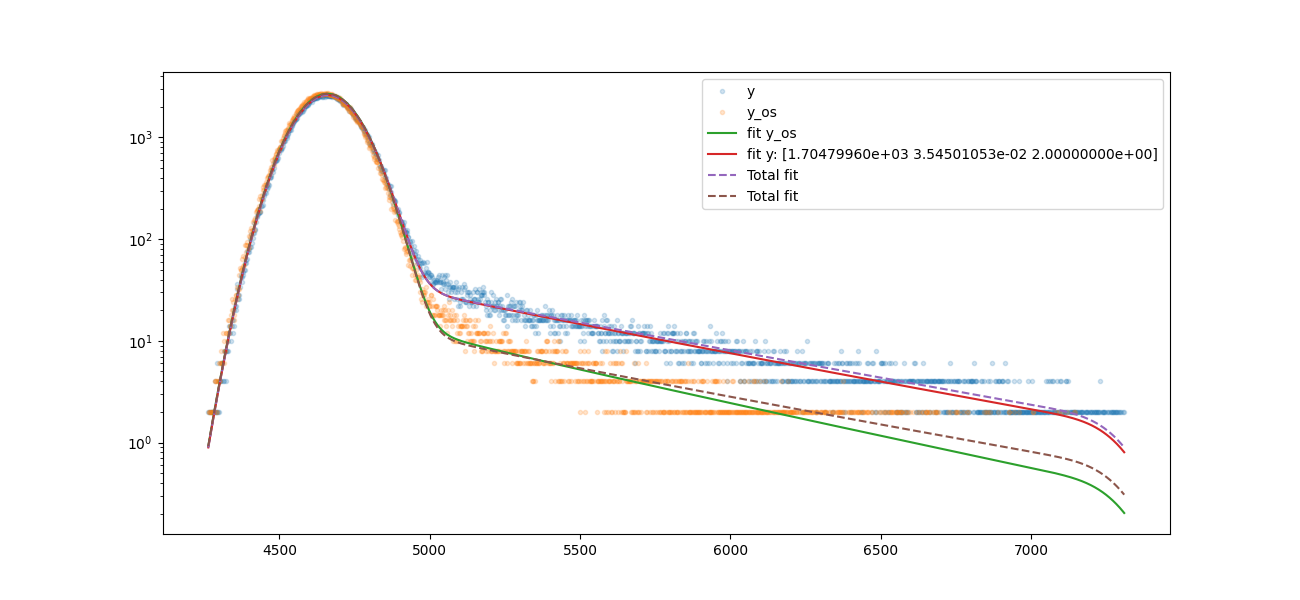

In [2]:
self=a


self.bias_w.value, self.rn_w.value, self.gain_w.value, flux, self.smearing_w.value, self.sCIC_w.value = init_values(self.x,self.y,self.y_os)
self.flux_w.value = [0,flux]
# print(bias, RN, emgain, flux, smearing, sCIC)
# FITTING RN, GAIN, FLUX, CIC

print(self.bias_w.value,)
self.function_os = lambda bins, RN, EmGain, flux1, sCIC:EMCCD(bins, bias=self.bias_w.value, RN=RN, EmGain=EmGain, flux=flux1, smearing=self.smearing_w.value, sCIC=sCIC)



p0 = [self.rn_w.value, self.gain_w.value, flux, self.sCIC_w.value]
# print('p0Rn %0.1f, gain %i flux %0.2f, scic %0.3f'%(*p0,))
# popt,pcov = curve_fit(function,self.x,self.y,p0=p0,epsfcn=1)#[xdata < upper_limit]
val_max = np.percentile(self.x,90)
# print(val_max)
bounds=[[self.bias_w.value-100,0,1000,0.001,0.002],[self.bias_w.value+100,150,2300,1,0.005]]
mask = (self.x<val_max) & np.isfinite(np.log10(self.y))
mask_os = (self.x<val_max) & np.isfinite(np.log10(self.y_os))
# print(self.x[mask],self.y[mask])
self.function = lambda bins, bias,RN, EmGain, flux1, sCIC:EMCCD(bins, bias=bias, RN=RN, EmGain=EmGain, flux=flux1, smearing=self.smearing_w.value, sCIC=sCIC)
# self.popt , pcov = curve_fit(self.function,self.x[mask_os],np.log10(self.y_os[mask_os]),p0=p0)#,epsfcn=1)#[xdata < upper_limit]
self.popt , pcov = curve_fit(self.function,self.x[mask_os],np.log10(self.y_os[mask_os]),bounds=bounds)#,epsfcn=1)#[xdata < upper_limit]
self.bias_w.value,self.rn_w.value, self.gain_w.value, flux, self.sCIC_w.value = self.popt

print(self.popt)


# popt,pcov = curve_fit(function,self.x[mask],np.log10(self.y_conv[mask]),p0=p0,bounds=bounds)#[xdata < upper_limit]
# print('popt Rn %0.1f, gain %i flux %0.2f, scic %0.3f'%(*popt,))
# print('diff Rn %0.1f, gain %i flux %0.2f, scic %0.3f'%(*list(np.array(p0)-np.array(popt)),))
p0_gain_flux=[self.gain_w.value, flux]
self.function_noCIC = lambda bins, EmGain, flux1,smearing: EMCCD(bins, bias=self.bias_w.value, RN=self.rn_w.value, EmGain=EmGain, flux=flux1, smearing=smearing, sCIC=self.sCIC_w.value)
bounds=[[100,0,0],[4000,1,2]]
self.popt_gain_flux,pcov = curve_fit(self.function_noCIC,self.x[mask],np.log10(self.y[mask]),bounds=bounds)#[xdata < upper_limit]
# plt.semilogy(self.x,10**self.function_noCIC(self.x,*p0_gain_flux),label="fit P0 y %s"%(p0_gain_flux))

self.gain_w.value, self.flux_w.value, self.smearing_w.value= self.popt_gain_flux[0], [flux,self.popt_gain_flux[1]],self.popt_gain_flux[2]

# self.function_gain_smearing = lambda bins, EmGain, smearing: EMCCD(bins, bias=self.bias_w.value, RN=self.rn_w.value, EmGain=EmGain, flux=self.popt_gain_flux[1], smearing=smearing, sCIC=self.sCIC_w.value)
# self.popt_gain_smearing,pcov = curve_fit(self.function_gain_smearing,self.x[mask],np.log10(self.y[mask]),bounds=[[100,0],[4000,1.5]])#[xdata < upper_limit]



if 1==1:
    plt.figure(figsize=(13,6))
    plt.semilogy(self.x,self.y,".",alpha=0.2,label="y")
    plt.semilogy(self.x,self.y_os,".",alpha=0.2,label="y_os")
    plt.semilogy(self.x,10**self.function(self.x,*self.popt),label="fit y_os")
    plt.semilogy(self.x,10**self.function_noCIC(self.x,*self.popt_gain_flux),label="fit y: %s"%(self.popt_gain_flux))
    plt.semilogy(self.x,10**EMCCD(self.x, bias=self.bias_w.value, RN=self.rn_w.value, EmGain=self.gain_w.value, flux=self.flux_w.value[1], smearing=self.smearing_w.value, sCIC=self.sCIC_w.value),"--",label="Total fit")
    plt.semilogy(self.x,10**EMCCD(self.x, bias=self.bias_w.value, RN=self.rn_w.value, EmGain=self.gain_w.value, flux=self.flux_w.value[0], smearing=self.smearing_w.value, sCIC=self.sCIC_w.value),"--",label="Total fit")


    # plt.semilogy(self.x,10**EMCCD(self.x, bias=self.bias_w.value, RN=self.rn_w.value, EmGain=self.popt_gain_smearing[0], flux=self.flux_w.value[1], smearing=self.popt_gain_smearing[1], sCIC=self.sCIC_w.value),":",label="Total fit")
    # plt.semilogy(self.x,10**EMCCD(self.x, bias=self.bias_w.value, RN=self.rn_w.value, EmGain=self.popt_gain_smearing[0], flux=self.flux_w.value[0], smearing=self.popt_gain_smearing[1], sCIC=self.sCIC_w.value),":",label="Total fit")


    plt.legend()
    # plt.semilogy(self.x,10**EMCCD(self.x, bias=self.bias_w.value, RN=self.rn_w.value, EmGain=self.gain_w.value, flux=0, smearing=self.smearing_w.value, sCIC=self.flux_w.value[0]))
    plt.show()
# self.bias_w.value, self.bias_w.max, self.bias_w.min

4214.6509433962265
p0Rn 20.0, gain 500 flux 0.02, scic 0.005
5619.056603773584
[[4114.6509433962265, 0, 100, 0.001, 0.002], [4314.6509433962265, 150, 2500, 1, 0.005]] [4214.6509433962265, 20, 1000, 0.2, 0.0001]
4224.6509433962265


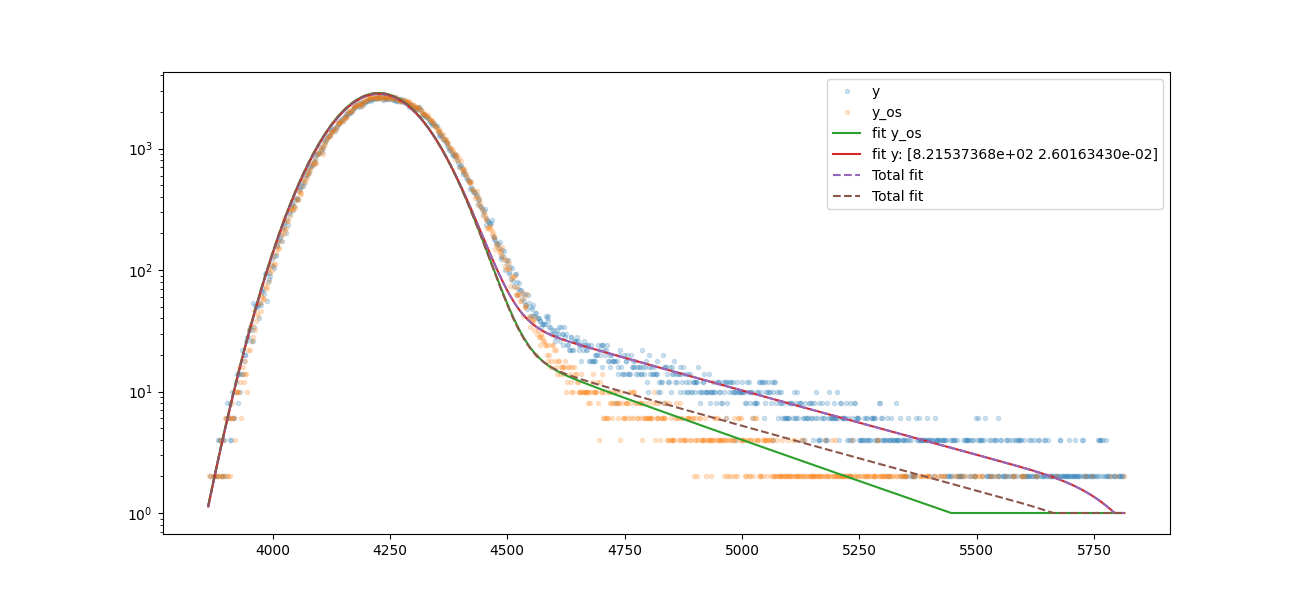

In [34]:
self=a


self.bias_w.value, self.rn_w.value, self.gain_w.value, flux, self.smearing_w.value, self.sCIC_w.value = init_values(self.x,self.y,self.y_os)
self.flux_w.value = [0,flux]
# print(bias, RN, emgain, flux, smearing, sCIC)
# FITTING RN, GAIN, FLUX, CIC

print(self.bias_w.value,)


p0 = [self.rn_w.value, self.gain_w.value, flux, self.sCIC_w.value]
print('p0Rn %0.1f, gain %i flux %0.2f, scic %0.3f'%(*p0,))
# popt,pcov = curve_fit(function,self.x,self.y,p0=p0,epsfcn=1)#[xdata < upper_limit]
val_max = np.percentile(self.x,90)
print(val_max)
bounds=[[self.bias_w.value-100,0,100,0.001,0.002],[self.bias_w.value+100,150,2500,1,0.005]]
mask = (self.x<val_max) & np.isfinite(np.log10(self.y))
mask_os = (self.x<val_max) & np.isfinite(np.log10(self.y_os))
# print(self.x[mask],self.y[mask])
self.function = lambda bins, bias, RN, EmGain, flux1, sCIC:EMCCD(bins, bias=bias, RN=RN, EmGain=EmGain, flux=flux1, smearing=self.smearing_w.value, sCIC=sCIC)
# self.popt , pcov = curve_fit(self.function,self.x[mask_os],np.log10(self.y_os[mask_os]),p0=p0)#,epsfcn=1)#[xdata < upper_limit]
print(bounds,[self.bias_w.value,20,1000,0.2,0.0001])
self.popt , pcov = curve_fit(self.function,self.x[mask_os],np.log10(self.y_os[mask_os]),bounds=bounds,p0=[self.bias_w.value+10,20,1000,0.2,0.003])#,epsfcn=1)#[xdata < upper_limit]
self.bias_w.value,self.rn_w.value, self.gain_w.value, flux, self.sCIC_w.value = self.popt
print(self.bias_w.value,)



# popt,pcov = curve_fit(function,self.x[mask],np.log10(self.y_conv[mask]),p0=p0,bounds=bounds)#[xdata < upper_limit]
# print('popt Rn %0.1f, gain %i flux %0.2f, scic %0.3f'%(*popt,))
# print('diff Rn %0.1f, gain %i flux %0.2f, scic %0.3f'%(*list(np.array(p0)-np.array(popt)),))
p0_gain_flux=[self.gain_w.value, flux]
self.function_noCIC = lambda bins, EmGain, flux1: EMCCD(bins, bias=self.bias_w.value, RN=self.rn_w.value, EmGain=EmGain, flux=flux1, smearing=self.smearing_w.value, sCIC=self.sCIC_w.value)
bounds=[[100,0],[4000,1]]
self.popt_gain_flux,pcov = curve_fit(self.function_noCIC,self.x[mask],np.log10(self.y[mask]),bounds=bounds)#[xdata < upper_limit]
# plt.semilogy(self.x,10**self.function_noCIC(self.x,*p0_gain_flux),label="fit P0 y %s"%(p0_gain_flux))

self.gain_w.value, self.flux_w.value= self.popt_gain_flux[0], [flux,self.popt_gain_flux[1]]

# self.function_gain_smearing = lambda bins, EmGain, smearing: EMCCD(bins, bias=self.bias_w.value, RN=self.rn_w.value, EmGain=EmGain, flux=self.popt_gain_flux[1], smearing=smearing, sCIC=self.sCIC_w.value)
# self.popt_gain_smearing,pcov = curve_fit(self.function_gain_smearing,self.x[mask],np.log10(self.y[mask]),bounds=[[100,0],[4000,1.5]])#[xdata < upper_limit]



if 1==1:
    plt.figure(figsize=(13,6))
    plt.semilogy(self.x,self.y,".",alpha=0.2,label="y")
    plt.semilogy(self.x,self.y_os,".",alpha=0.2,label="y_os")
    plt.semilogy(self.x,10**self.function(self.x,*self.popt),label="fit y_os")
    plt.semilogy(self.x,10**self.function_noCIC(self.x,*self.popt_gain_flux),label="fit y: %s"%(self.popt_gain_flux))
    plt.semilogy(self.x,10**EMCCD(self.x, bias=self.bias_w.value, RN=self.rn_w.value, EmGain=self.gain_w.value, flux=self.flux_w.value[1], smearing=self.smearing_w.value, sCIC=self.sCIC_w.value),"--",label="Total fit")
    plt.semilogy(self.x,10**EMCCD(self.x, bias=self.bias_w.value, RN=self.rn_w.value, EmGain=self.gain_w.value, flux=self.flux_w.value[0], smearing=self.smearing_w.value, sCIC=self.sCIC_w.value),"--",label="Total fit")


    # plt.semilogy(self.x,10**EMCCD(self.x, bias=self.bias_w.value, RN=self.rn_w.value, EmGain=self.popt_gain_smearing[0], flux=self.flux_w.value[1], smearing=self.popt_gain_smearing[1], sCIC=self.sCIC_w.value),":",label="Total fit")
    # plt.semilogy(self.x,10**EMCCD(self.x, bias=self.bias_w.value, RN=self.rn_w.value, EmGain=self.popt_gain_smearing[0], flux=self.flux_w.value[0], smearing=self.popt_gain_smearing[1], sCIC=self.sCIC_w.value),":",label="Total fit")


    plt.legend()
    # plt.semilogy(self.x,10**EMCCD(self.x, bias=self.bias_w.value, RN=self.rn_w.value, EmGain=self.gain_w.value, flux=0, smearing=self.smearing_w.value, sCIC=self.flux_w.value[0]))
    plt.show()
# self.bias_w.value, self.bias_w.max, self.bias_w.min

In [11]:
a.popt_gain_flux

array([8.81595300e+02, 4.31242141e-03])

In [37]:
a.x

4263.207547169811
4265.094339622641
4266.981132075472
4268.867924528302
4270.754716981131
4272.641509433962
4274.528301886792
4276.415094339623
4278.301886792453
4280.188679245282
4282.075471698113


In [50]:
import time
time.sleep(1)